In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import awkward as ak

import matplotlib.pylab as plt
import numpy as np

import time

from hist import Hist

import babar_analysis_tools as bat

from analysis_variables import *

import myPIDselector

import pandas as pd
import seaborn as sns

import ROOT
import pdf_definitions as pdfs

Welcome to JupyROOT 6.30/02


In [2]:
h = ROOT.TH1F()

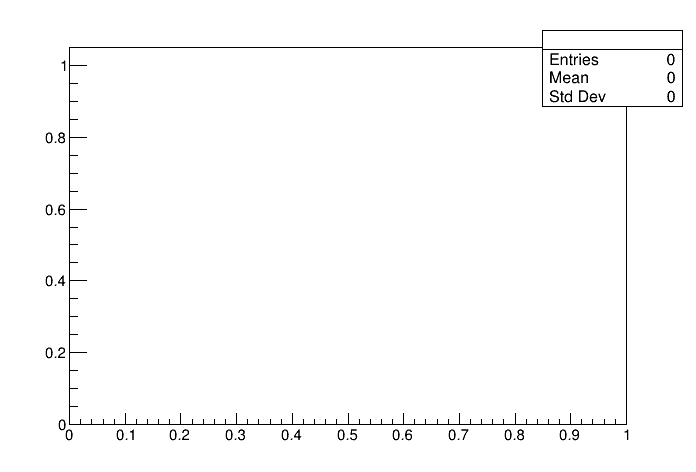

In [3]:

c1 = ROOT.TCanvas()
c1.cd()
h.Draw()

c1.Update()

#c1.Show()

# rf202

In [ ]:
# Declare observable x
x = ROOT.RooRealVar("x", "x", 0, 10)

# Create two Gaussian PDFs g1(x,mean1,sigma) anf g2(x,mean2,sigma) and
# their parameters
mean = ROOT.RooRealVar("mean", "mean of gaussians", 5)
sigma1 = ROOT.RooRealVar("sigma1", "width of gaussians", 0.5)
sigma2 = ROOT.RooRealVar("sigma2", "width of gaussians", 1)

sig1 = ROOT.RooGaussian("sig1", "Signal component 1", x, mean, sigma1)
sig2 = ROOT.RooGaussian("sig2", "Signal component 2", x, mean, sigma2)

# Build Chebychev polynomial p.d.f.
a0 = ROOT.RooRealVar("a0", "a0", 0.5, 0., 1.)
a1 = ROOT.RooRealVar("a1", "a1", -0.2, 0., 1.)
bkg = ROOT.RooChebychev("bkg", "Background", x, ROOT.RooArgList(a0, a1))

# Sum the signal components into a composite signal p.d.f.
sig1frac = ROOT.RooRealVar(
    "sig1frac", "fraction of component 1 in signal", 0.8, 0., 1.)
sig = ROOT.RooAddPdf(
    "sig", "Signal", ROOT.RooArgList(sig1, sig2), ROOT.RooArgList(sig1frac))



In [ ]:
# Method 1 - Construct extended composite model
# -------------------------------------------------------------------

# Sum the composite signal and background into an extended pdf
# nsig*sig+nbkg*bkg
nsig = ROOT.RooRealVar("nsig", "number of signal events", 500, 0., 10000)
nbkg = ROOT.RooRealVar(
    "nbkg", "number of background events", 500, 0, 10000)
model = ROOT.RooAddPdf(
    "model",
    "(g1+g2)+a",
    ROOT.RooArgList(
        bkg,
        sig),
    ROOT.RooArgList(
        nbkg,
        nsig))

# Sample, fit and plot extended model
# ---------------------------------------------------------------------

# Generate a data sample of expected number events in x from model
# = model.expectedEvents() = nsig+nbkg
data = model.generate(ROOT.RooArgSet(x))

# Fit model to data, ML term automatically included
model.fitTo(data)

# Plot data and PDF overlaid, expected number of events for p.d.f projection normalization
# rather than observed number of events (==data.numEntries())
xframe = x.frame(ROOT.RooFit.Title("extended ML fit example"))
data.plotOn(xframe)
model.plotOn(xframe, ROOT.RooFit.Normalization(
    1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_bkg = ROOT.RooArgSet(bkg)
model.plotOn(
    xframe, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background+sig2 components of model with a dotted line
ras_bkg_sig2 = ROOT.RooArgSet(bkg, sig2)
model.plotOn(
    xframe, ROOT.RooFit.Components(ras_bkg_sig2), ROOT.RooFit.LineStyle(
        ROOT.kDotted), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))


In [ ]:
# Print structure of composite p.d.f.
model.Print("t")


# Method 2 - Construct extended components first
# ---------------------------------------------------------------------

# Associated nsig/nbkg as expected number of events with sig/bkg
esig = ROOT.RooExtendPdf("esig", "extended signal p.d.f", sig, nsig)
ebkg = ROOT.RooExtendPdf("ebkg", "extended background p.d.f", bkg, nbkg)

# Sum extended components without coefs
# -------------------------------------------------------------------------

# Construct sum of two extended p.d.f. (no coefficients required)
model2 = ROOT.RooAddPdf("model2", "(g1+g2)+a", ROOT.RooArgList(ebkg, esig))

# Draw the frame on the canvas
c = ROOT.TCanvas("rf202_extendedmlfit", "rf202_extendedmlfit", 600, 600)
ROOT.gPad.SetLeftMargin(0.15)
xframe.GetYaxis().SetTitleOffset(1.4)
xframe.Draw()

c.Update()

c.SaveAs("rf202_extendedmlfit.png")


# From ChatGPT

In [ ]:
c = ROOT.TCanvas("testingfits", "testingfits")#"fit", "fit", 600, 600)

In [ ]:
#df = pd.read_parquet('mes_deltae_background_AFTER_FINAL_CUTS.parquet')
#df

In [ ]:
mes_lo, mes_hi = 5.2,5.3
deltae_lo, deltae_hi = -0.2,0.2

x,y = pdfs.build_xy([[mes_lo, mes_hi], [deltae_lo, deltae_hi]])


x.setRange("FULL",mes_lo,mes_hi)
y.setRange("FULL",deltae_lo, deltae_hi)

x.setRange("SIGNAL",5.25, mes_hi)
y.setRange("SIGNAL",-0.10, 0.1)

# Sideband 1 region
x.setRange("SB1", mes_lo,  mes_hi)
y.setRange("SB1", 0.075, deltae_hi)

# Sideband 2 region
x.setRange("SB2",  mes_lo,  mes_hi)
y.setRange("SB2", deltae_lo, -0.075)

# Sideband 3 region
x.setRange("SB3",  mes_lo,  5.27)
y.setRange("SB3", -0.075, 0.075)



In [ ]:
#dim = 2

#dum_pars, sub_funcs_list, total = pdfs.tot_PDF(x,y, data_z,
#:dim, use_double_cb, workspace)

pars_bkg, bkg_pdf = pdfs.argus_in_x(x)
pars_sig, sig_pdf = pdfs.crystal_barrel_x(x)

conv_factor_fit  = ROOT.RooRealVar("conv_factor_fit", "Conversion factor (fit)",10) # Conversion factor, fit
branching_fraction = ROOT.RooRealVar("branching_fraction","Branching fraction",1)


nbkg = ROOT.RooRealVar("nbkg","# bkg events,",10)
nsig = ROOT.RooFormulaVar("nsig","conv_factor_fit*branching_fraction",ROOT.RooArgList(convmes_lo, mes_hi = 5.2,5.3))
deltae_lo, deltae_hi = -0.2,0.2

x,y = pdfs.build_xy([[mes_lo, mes_hi], [deltae_lo, deltae_hi]])


x.setRange("FULL",mes_lo,mes_hi)
y.setRange("FULL",deltae_lo, deltae_hi)

x.setRange("SIGNAL",5.25, mes_hi)
y.setRange("SIGNAL",-0.10, 0.1)

# Sideband 1 region
x.setRange("SB1", mes_lo,  mes_hi)
y.setRange("SB1", 0.075, deltae_hi)

# Sideband 2 region
x.setRange("SB2",  mes_lo,  mes_hi)
y.setRange("SB2", deltae_lo, -0.075)

# Sideband 3 region
x.setRange("SB3",  mes_lo,  5.27)
y.setRange("SB3", -0.075, 0.075)
_factor_fit,branching_fraction))


total = ROOT.RooAddPdf("total","sig_pdf + bkg_pdf", ROOT.RooArgList(sig_pdf, bkg_pdf), ROOT.RooArgList(nsig, nbkg))

pars = [nbkg, nsig]
pars += pars_sig
pars += pars_bkg


In [ ]:
conv_factor_fit.setVal(4)
nbkg.setVal(9)

data = total.generate(ROOT.RooArgSet(x))
conv_factor_fit.setConstant(False)

nbkg.setConstant(False)

# Fit model to data, ML term automatically included
'''
result = total.fitTo(data, ROOT.RooFit.Extended(ROOT.kTRUE),
                                         ROOT.RooFit.Save(ROOT.kTRUE),
                                         ROOT.RooFit.Strategy(2),
                                         ROOT.RooFit.PrintLevel(-1))
'''
nll = ROOT.RooNLLVar("nll","nll",total,data,ROOT.RooFit.Extended(ROOT.kTRUE))
#fit_func = RooFormulaVar("fit_func","nll + log_gc",RooArgList(nll,pars_d["log_gc"]))
fit_func = ROOT.RooFormulaVar("fit_func","nll",ROOT.RooArgList(nll))

m = ROOT.RooMinimizer(fit_func)
m.setVerbose(ROOT.kFALSE)
m.migrad()
m.hesse()
result = m.save()



result.Print("v")



In [ ]:
result.Print('v')

In [ ]:
del c
c = ROOT.TCanvas("testingfits", "testingfits", 600, 300)#"fit", "fit", 600, 600)
# Plot data and PDF overlaid, expected number of events for p.d.f projection normalization
# rather than observed number of events (==data.numEntries())
xframe = x.frame(ROOT.RooFit.Title("extended ML fit example"), ROOT.RooFit.Bins(25))
data.plotOn(xframe)
total.plotOn(xframe, ROOT.RooFit.Normalization(
    1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_bkg = ROOT.RooArgSet(bkg_pdf)
total.plotOn(
    xframe, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_sig = ROOT.RooArgSet(sig_pdf)
total.plotOn(
    xframe, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(
        ROOT.kDotted), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Draw the frame on the canvas

ROOT.gPad.SetLeftMargin(0.15)
xframe.GetYaxis().SetTitleOffset(1.4)
xframe.Draw()



#c.Update()
#ROOT.gPad
c.Draw()
#ROOT.gPad.Draw()
#ROOT.gPad.Update()
#c.Draw()

#c.SaveAs("testfit.png")


In [4]:
def read_file_return_dataset(df, x, y, region_definitions=None, dim=2, max_events=1e9, index=0):
    
    nevents=0
    name = f"dataset_{index}"
    ds = ROOT.RooDataSet(name, name, ROOT.RooArgSet(x,y) )

    # mES ranges
    x_lo = region_definitions['fitting MES'][0]
    x_hi = region_definitions['fitting MES'][1]
    # DeltaE ranges
    y_lo = region_definitions['fitting DeltaE'][0]
    y_hi = region_definitions['fitting DeltaE'][1]

    print("Data ranges...")
    print(x_lo, x_hi)
    print(y_lo, y_hi)
    
    mes, deltae = df['BpostFitMes'].values, df['BpostFitDeltaE'].values

    for m,de in zip(mes, deltae):
        x.setVal(m)
        y.setVal(de)

        if nevents<max_events:
            #print "%3.3f %3.3f %3.3f" % (x.getVal(), y.getVal(), z.getVal())
            #print "\t%3.3f %3.3f" % (x_lo, x_hi)
            #print "\t%3.3f %3.3f" % (y_lo, y_hi)
            #print "\t%3.3f %3.3f" % (z_lo, z_hi)
            #print "here"

            if x.getVal()>x_lo and x.getVal()<x_hi and \
               y.getVal()>y_lo and y.getVal()<y_hi:
                #if y.getVal()>y_lo and y.getVal()<y_hi:
                # Run this check otherwise the fit won't converge.
                #print "Adding...."
                ds.add(ROOT.RooArgSet(x,y))
                nevents += 1
                #print "Added event --------------"
            '''
            else:
                print "NOT ADDING EVENT ========+++++++++===========++++++++++++"
            '''
        else:
            #print "hi"
            break

    #print "Here is hte nevents: %d %f" % (nevents, max_events)
    return ds


In [ ]:
#df_sp = pd.read_parquet("DATAFRAME_SP.parquet")
#df_col = pd.read_parquet("DATAFRAME_COL.parquet")

df_sp = pd.read_parquet("DATAFRAME_SP_BNC_ALL.parquet")
df_col = pd.read_parquet("DATAFRAME_COL_BNC_ALL.parquet")

In [ ]:
#mask = (df_sp['spmode']=='998')
mask = (df_sp['used_in_bkg_train'] == False)
mask &= mask & (df_sp['used_in_sig_train'] == False)
mask &= mask & (df_sp['cut_2']==True) & (df_sp['cut_3']==True)  & (df_sp['cut_4']==True)
mask = mask & (df_sp['BpostFitDeltaE']<0.05) & (df_sp['BpostFitDeltaE']>-0.05)
mask &= mask & (df_sp['proba']>0.97)

mask_sp = (df_sp['spmode']=='998')
df_tmp1 = df_sp[mask & mask_sp]

mask_sp = (df_sp['spmode']=='-999')
df_tmp2 = df_sp[mask & mask_sp].sample(n=4)

df_tmp = pd.concat([df_tmp1, df_tmp2])

#ds = read_file_return_dataset(df_sp[mask], x, y, region_definitions=region_definitions)
ds = read_file_return_dataset(df_tmp, x, y, region_definitions=region_definitions)

In [ ]:
ds.Print("v")

In [ ]:
ds_x = ds.reduce(x)

ds_x.Print("v")

In [ ]:
ds_x.sumEntries()

In [ ]:
#dim = 2

#dum_pars, sub_funcs_list, total = pdfs.tot_PDF(x,y, data_z,
#:dim, use_double_cb, workspace)

pars_bkg, bkg_pdf = pdfs.argus_in_x(x)
pars_sig, sig_pdf = pdfs.crystal_barrel_x(x)

conv_factor_fit  = ROOT.RooRealVar("conv_factor_fit", "Conversion factor (fit)",10) # Conversion factor, fit
branching_fraction = ROOT.RooRealVar("branching_fraction","Branching fraction",1)

nbkg = ROOT.RooRealVar("nbkg","# bkg events,",10)
nsig = ROOT.RooFormulaVar("nsig","conv_factor_fit*branching_fraction",ROOT.RooArgList(conv_factor_fit,branching_fraction))

total = ROOT.RooAddPdf("total","sig_pdf + bkg_pdf", ROOT.RooArgList(sig_pdf, bkg_pdf), ROOT.RooArgList(nsig, nbkg))

pars = [nbkg, nsig]
pars += pars_sig
pars += pars_bkg

conv_factor_fit.setVal(0.1)
nbkg.setVal(ds_x.sumEntries())
conv_factor_fit.setConstant(False)
nbkg.setConstant(False)

nll = ROOT.RooNLLVar("nll","nll",total, ds_x, ROOT.RooFit.Extended(ROOT.kTRUE))
#fit_func = RooFormulaVar("fit_func","nll + log_gc",RooArgList(nll,pars_d["log_gc"]))
fit_func = ROOT.RooFormulaVar("fit_func","nll",ROOT.RooArgList(nll))

m = ROOT.RooMinimizer(fit_func)
m.setVerbose(ROOT.kFALSE)
m.migrad()
m.hesse()
result = m.save()

result.Print("v")


xframe2 = x.frame(Title="Gaussian pdf with data")  # RooPlot

#del c2
c2 = ROOT.TCanvas("testingfits", "testingfits", 600, 300)#"fit", "fit", 600, 600)

ds.plotOn(xframe2)


total.plotOn(xframe2, ROOT.RooFit.Normalization(
    1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_bkg = ROOT.RooArgSet(bkg_pdf)
total.plotOn(
    xframe2, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_sig = ROOT.RooArgSet(sig_pdf)
total.plotOn(
    xframe2, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(
        ROOT.kDotted), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))




xframe2.Draw()
#c.Update()
#ROOT.gPad
c2.Draw()

# Full fit maybe?


## Read in the data files

In [5]:
#BNC_tag = ""
#BNC_bool = False
#ntrain_tag = 'nsig_20000_nbkg_20000'

BNC_tag = "_BNC"
BNC_bool = True
#ntrain_tag = 'nsig_30000_nbkg_30000'
#ntrain_tag = 'nsig_40000_nbkg_40000_trial0'
#ntrain_tag = 'nsig_40000_nbkg_40000_trial1'
#ntrain_tag = 'features_2_nsig_40000_nbkg_40000_trial0'
ntrain_tag = 'features_4_nsig_60000_nbkg_60000_trial1'


# Read in the dfs
infilename_sp = f"DATAFRAME_SP_MODEL_MLPClassifier_CUTS_1_2_3_{ntrain_tag}{BNC_tag}.pkl"
#df_sp = pd.read_parquet(infilename)

infilename_col = f"DATAFRAME_COL_MODEL_MLPClassifier_CUTS_1_2_3_{ntrain_tag}{BNC_tag}.pkl"
#df_col = pd.read_parquet(infilename)



In [6]:
df_sp = pd.read_parquet(infilename_sp)
df_col = pd.read_parquet(infilename_col)


#df_sp = pd.read_parquet("DATAFRAME_SP_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000_BNC.pkl")
#df_col = pd.read_parquet("DATAFRAME_COL_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000_BNC.pkl")

#df_sp = pd.read_parquet("DATAFRAME_SP_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000.pkl")
#df_col = pd.read_parquet("DATAFRAME_COL_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000.pkl")

In [7]:

mes_lo, mes_hi = 5.2,5.3
deltae_lo, deltae_hi = -0.2,0.2

x,y = pdfs.build_xy([[mes_lo, mes_hi], [deltae_lo, deltae_hi]])


x.setRange("FULL",mes_lo,mes_hi)
y.setRange("FULL",deltae_lo, deltae_hi)

x.setRange("SIGNAL",5.25, mes_hi)
y.setRange("SIGNAL",-0.10, 0.1)

# Sideband 1 region
x.setRange("SB1", mes_lo,  mes_hi)
y.setRange("SB1", 0.075, deltae_hi)

# Sideband 2 region
x.setRange("SB2",  mes_lo,  mes_hi)
y.setRange("SB2", deltae_lo, -0.075)

# Sideband 3 region
x.setRange("SB3",  mes_lo,  5.27)
y.setRange("SB3", -0.075, 0.075)



[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'FULL' created with bounds [5.2,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'FULL' created with bounds [-0.2,0.2]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SIGNAL' created with bounds [5.25,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SIGNAL' created with bounds [-0.1,0.1]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SB1' created with bounds [5.2,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SB1' created with bounds [0.075,0.2]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SB2' created with bounds [5.2,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SB2' created with bounds [-0.2,-0.075]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SB3' created with bounds [5.2,5.27]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SB3' created with bounds [-0.075,0.075]


In [8]:
ds_x = ds.reduce(x)

NameError: name 'ds' is not defined

In [ ]:
mypars = []

dum_pars, sub_funcs_list, total = pdfs.tot_PDF(x, ds_x)#, use_double_cb, workspace)

mypars += dum_pars


total.Print("v")

In [9]:
# Create a dictionary of the pars
# We'll use this later if we need to print stuff out.
#print mypars
pars_d = {}
for p in mypars:
    pars_d[p.GetName()] = p

# Create a dictionary of extra functions
# We'll use this later if we need to print stuff out.
#print sub_funcs_list
sub_funcs = {}
for f in sub_funcs_list:
    sub_funcs[f.GetName()] = f


NameError: name 'mypars' is not defined

In [10]:
for p in pars_d.keys():
    print(f"{p} ---------------------")
    #pars_d[p].Print("v")

In [11]:
df_sp = pd.read_parquet("DATAFRAME_SP_BNC_ALL.parquet")
df_col = pd.read_parquet("DATAFRAME_COL_BNC_ALL.parquet")

In [12]:
#mask = (df_sp['spmode']=='998')
mask = (df_sp['used_in_bkg_train'] == False)
mask &= mask & (df_sp['used_in_sig_train'] == False)
mask &= mask & (df_sp['cut_2']==True) & (df_sp['cut_3']==True) & (df_sp['cut_4']==True)
mask &= mask & (df_sp['BpostFitDeltaE']<0.05) & (df_sp['BpostFitDeltaE']>-0.05)
mask &= mask & (df_sp['proba']>0.90)

mask_sp = (df_sp['spmode']=='998')
df_tmp1 = df_sp[mask & mask_sp]

mask_sp = (df_sp['spmode']=='-999')
df_tmp2 = df_sp[mask & mask_sp].sample(n=5)

df_tmp = pd.concat([df_tmp1, df_tmp2])
#df_tmp = df_tmp1

#ds = read_file_return_dataset(df_sp[mask], x, y, region_definitions=region_definitions)
ds = read_file_return_dataset(df_tmp, x, y, region_definitions=region_definitions)

ds_x = ds.reduce(x)

ds_x.Print("v")

Data ranges...
5.2 5.3
-0.2 0.2
DataStore dataset_0 (dataset_0)
  Contains 39 entries
  Observables: 
    1)  x = 5.2807  L(5.2 - 5.3) // [GeV/c^{2}] "m_{ES}"


In [13]:
mypars = []
dum_pars, sub_funcs_list, total = pdfs.tot_PDF(x, ds_x)#, use_double_cb, workspace)
mypars += dum_pars
total.Print("v")

# Create a dictionary of the pars
# We'll use this later if we need to print stuff out.
#print mypars
pars_d = {}
for p in mypars:
    pars_d[p.GetName()] = p

# Create a dictionary of extra functions
# We'll use this later if we need to print stuff out.
#print sub_funcs_list
sub_funcs = {}
for f in sub_funcs_list:
    sub_funcs[f.GetName()] = f



# Background

pars_d["nbkg"].setVal(ds_x.sumEntries())
pars_d["nbkg"].setConstant(False)

pars_d["argpar"].setVal(-23.5)
pars_d["argpar"].setConstant(True)

pars_d["cutoff"].setVal(5.29)
pars_d["cutoff"].setConstant(True)

## Signal

pars_d["nCB"].setVal(1.0)
pars_d["nCB"].setConstant(True)

#pars_d["conv_factor_calc"].setVal(43.)
pars_d["conv_factor_calc"].setVal(13.)
pars_d["conv_factor_calc"].setConstant(True)

#pars_d["conv_factor_fit"].setVal(43.)
pars_d["conv_factor_fit"].setVal(13.)
pars_d["conv_factor_fit"].setConstant(False)

pars_d["conv_factor_err"].setVal(500)
pars_d["conv_factor_err"].setConstant(True)

#pars_d["branching_fraction"].setVal(0.58)
pars_d["branching_fraction"].setVal(12.2)
pars_d["branching_fraction"].setConstant(True)

pars_d["meanCB"].setVal(5.279)
pars_d["meanCB"].setConstant(True)

pars_d["sigmaCB"].setVal(0.0028)
pars_d["sigmaCB"].setConstant(True)

pars_d["alphaCB"].setVal(2.000)
pars_d["alphaCB"].setConstant(True)

# Bkg only

total.Print("v")

# Create the NLL for the fit
nll = ROOT.RooNLLVar("nll","nll", total, ds_x, ROOT.RooFit.Extended(ROOT.kTRUE))
fit_func = ROOT.RooFormulaVar("fit_func","nll + log_gc",ROOT.RooArgList(nll,pars_d["log_gc"]))

m = ROOT.RooMinimizer(fit_func)

m.setVerbose(ROOT.kFALSE)

m.migrad()
m.hesse()
fit_results = m.save()


fit_results.Print("v")
mynsig = pars_d["conv_factor_fit"].getVal() * pars_d["branching_fraction"].getVal()
print(f"mynsig: {mynsig}    nsig: {pars_d['nsig'].getVal()}")



mynsig: 8.24520823093513    nsig: 8.24520823093513
[#1] INFO:InputArguments -- The formula log_gc claims to use the variables (conv_factor_calc,conv_factor_fit,conv_factor_calc,conv_factor_fit,conv_factor_err,conv_factor_err) but only (conv_factor_calc,conv_factor_fit,conv_factor_err) seem to be in use.
  inputs:         (conv_factor_calc-conv_factor_fit)*(conv_factor_calc-conv_factor_fit)/(2.0*conv_factor_err*conv_factor_err)
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes: 
  Address: 0x561e02057820
  Clients: 
  Servers: 
    (0x561e01df1870,V-) RooCBShape::sig_pdf "Crystal Barrel Shape PDF"
    (0x561e00c74b40,V-) RooFormulaVar::nsig "conv_factor_fit*branching_fraction"
    (0x561dffcff840,V-) RooArgusBG::bkg_pdf "Argus PDF"
    (0x561e01c80e50,V-) RooRealVar::nbkg "# bkg events,"
  Proxies: 
    !refCoefNorm -> 
    !pdfs -> 
      1)  sig_pdf
      2)  bkg_pdf
    !coefficients -> 
      1)  nsig
      2)  nbkg
--- RooAbsReal ---

  Plot label is "total"


Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -85.29059828 Edm =       807.6529853 NCalls =      9
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -85.29059828
  Edm           : 807.6529853
  Internal parameters:	[               13               39]	
  Internal gradient  :	[      10.89103791      0.436320097]	
  Internal covariance matrix:
[[      26.957266              0]
 [              0      173.78195]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -85.29059828 Edm =       807.6529853 NCalls =      9
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -198.3284055 Edm =       1430.799783 NCalls =     21
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =      -200.7985234 Edm =       1.774171048 NCalls =     31
Info in <Minuit2>: VariableMet

In [ ]:
fit_results.Print("v")
print()
mynsig = pars_d["conv_factor_fit"].getVal() * pars_d["branching_fraction"].getVal()
print(f"mynsig: {mynsig}    nsig: {pars_d['nsig'].getVal()}")


In [ ]:
#del c
c4 = ROOT.TCanvas("testingfits4", "testingfits4", 600, 300)#"fit", "fit", 600, 600)
# Plot data and PDF overlaid, expected number of events for p.d.f projection normalization
# rather than observed number of events (==data.numEntries())
xframe4 = x.frame(ROOT.RooFit.Title("extended ML fit example"), ROOT.RooFit.Bins(25))
ds_x.plotOn(xframe4)
total.plotOn(xframe4, ROOT.RooFit.Normalization(
    1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_bkg = ROOT.RooArgSet(bkg_pdf)
total.plotOn(
    xframe4, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_sig = ROOT.RooArgSet(sig_pdf)
total.plotOn(
    xframe4, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(
        ROOT.kDotted), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Draw the frame on the canvas

ROOT.gPad.SetLeftMargin(0.15)
xframe4.GetYaxis().SetTitleOffset(1.4)
xframe4.Draw()



#c.Update()
#ROOT.gPad
c4.Draw()
#ROOT.gPad.Draw()
#ROOT.gPad.Update()
#c.Draw()

#c.SaveAs("testfit.png")


# Start here

## Background

In [211]:
#BNC_tag = ""
#BNC_bool = False
#ntrain_tag = 'nsig_20000_nbkg_20000'

BNC_tag = "_BNC"
BNC_bool = True
#ntrain_tag = 'nsig_30000_nbkg_30000'
#ntrain_tag = 'nsig_40000_nbkg_40000_trial0'
#ntrain_tag = 'nsig_40000_nbkg_40000_trial1'
#ntrain_tag = 'features_2_nsig_40000_nbkg_40000_trial0'
ntrain_tag = 'features_4_nsig_60000_nbkg_60000_trial3'


# Read in the dfs
infilename_sp = f"DATAFRAME_SP_MODEL_MLPClassifier_CUTS_1_2_3_{ntrain_tag}{BNC_tag}.pkl"
#df_sp = pd.read_parquet(infilename)

infilename_col = f"DATAFRAME_COL_MODEL_MLPClassifier_CUTS_1_2_3_{ntrain_tag}{BNC_tag}.pkl"
#df_col = pd.read_parquet(infilename)



In [212]:
df_sp = pd.read_parquet(infilename_sp)
df_col = pd.read_parquet(infilename_col)

#df_sp = pd.read_parquet("DATAFRAME_SP_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000.pkl")
#df_col = pd.read_parquet("DATAFRAME_COL_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000.pkl")


proba_cut = 0.82

In [213]:
# BNC
mes_lo, mes_hi = 5.2,5.3

# Trying this for BNV
#mes_lo, mes_hi = 5.21,5.3

#deltae_lo, deltae_hi = -0.2,0.2
deltae_lo, deltae_hi = -0.07,0.07

x,y = pdfs.build_xy([[mes_lo, mes_hi], [deltae_lo, deltae_hi]])


x.setRange("FULL",mes_lo,mes_hi)
y.setRange("FULL",deltae_lo, deltae_hi)

x.setRange("SIGNAL",5.25, mes_hi)
y.setRange("SIGNAL",-0.10, 0.1)

# Sideband 1 region
x.setRange("SB1", mes_lo,  mes_hi)
y.setRange("SB1", 0.075, deltae_hi)

# Sideband 2 region
x.setRange("SB2",  mes_lo,  mes_hi)
y.setRange("SB2", deltae_lo, -0.075)

# Sideband 3 region
x.setRange("SB3",  mes_lo,  5.27)
#y.setRange("SB3", -0.075, 0.075)
y.setRange("SB3", -0.05, 0.05)




[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'FULL' created with bounds [5.2,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'FULL' created with bounds [-0.07,0.07]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SIGNAL' created with bounds [5.25,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SIGNAL' created with bounds [-0.1,0.1]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SB1' created with bounds [5.2,5.3]
[#0] WARNING:InputArguments -- RooRealVar::setRange(y): Proposed new fit max. smaller than min., setting max. to min.
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SB1' created with bounds [0.075,0.07]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SB2' created with bounds [5.2,5.3]
[#0] WARNING:InputArguments -- RooRealVar::setRange(y): Proposed new fit max. smaller than min., setting max. to min.
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SB2' created with bounds [-0.0

In [214]:
# BNC
mask = (df_sp['used_in_bkg_train'] == False)
mask &= mask & (df_sp['used_in_sig_train'] == False)
mask &= mask & (df_sp['cut_2']==True) & (df_sp['cut_3']==True) & (df_sp['cut_4']==True)
mask &= mask & (df_sp['BpostFitDeltaE']<0.05) & (df_sp['BpostFitDeltaE']>-0.05)
mask &= mask & (df_sp['proba']>proba_cut)

mask_sp = (df_sp['spmode']!='-999')
df_tmp1 = df_sp[mask & mask_sp]


# BNV
'''
#mask = (df_sp['spmode']=='998')
mask = (df_sp['used_in_bkg_train'] == False)
mask &= mask & (df_sp['cut_-1']==True)
mask &= mask & (df_sp['BpostFitDeltaE']<0.07) & (df_sp['BpostFitDeltaE']>-0.07)
mask &= mask & (df_sp['proba']>0.84)
'''

mask_sp = (df_sp['spmode']=='998')
df_tmp1 = df_sp[mask & mask_sp]



#mask_sp = (df_sp['spmode']=='-999')
#df_tmp2 = df_sp[mask & mask_sp].sample(n=4)

#df_tmp = pd.concat([df_tmp1, df_tmp2])
df_tmp = df_tmp1

#ds = read_file_return_dataset(df_sp[mask], x, y, region_definitions=region_definitions)
ds = read_file_return_dataset(df_tmp, x, y, region_definitions=region_definitions)

ds_x = ds.reduce(x)

ds_x.Print("v")

Data ranges...
5.2 5.3
-0.2 0.2
DataStore dataset_0 (dataset_0)
  Contains 59 entries
  Observables: 
    1)  x = 5.223  L(5.2 - 5.3) // [GeV/c^{2}] "m_{ES}"


In [215]:
#df_tmp

mypars = []
dum_pars, sub_funcs_list, total = pdfs.tot_PDF(x, ds_x)#, use_double_cb, workspace)
mypars += dum_pars
total.Print("v")

# Create a dictionary of the pars
# We'll use this later if we need to print stuff out.
#print mypars
pars_d = {}
for p in mypars:
    pars_d[p.GetName()] = p

# Create a dictionary of extra functions
# We'll use this later if we need to print stuff out.
#print sub_funcs_list
sub_funcs = {}
for f in sub_funcs_list:
    sub_funcs[f.GetName()] = f


[#1] INFO:InputArguments -- The formula log_gc claims to use the variables (conv_factor_calc,conv_factor_fit,conv_factor_calc,conv_factor_fit,conv_factor_err,conv_factor_err) but only (conv_factor_calc,conv_factor_fit,conv_factor_err) seem to be in use.
  inputs:         (conv_factor_calc-conv_factor_fit)*(conv_factor_calc-conv_factor_fit)/(2.0*conv_factor_err*conv_factor_err)
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes: 
  Address: 0x561e06ce3d90
  Clients: 
  Servers: 
    (0x561e06cf26c0,V-) RooCBShape::sig_pdf "Crystal Barrel Shape PDF"
    (0x561e06cf6c20,V-) RooFormulaVar::nsig "conv_factor_fit*branching_fraction"
    (0x561e06cea560,V-) RooArgusBG::bkg_pdf "Argus PDF"
    (0x561e06cd9bd0,V-) RooRealVar::nbkg "# bkg events,"
  Proxies: 
    !refCoefNorm -> 
    !pdfs -> 
      1)  sig_pdf
      2)  bkg_pdf
    !coefficients -> 
      1)  nsig
      2)  nbkg
--- RooAbsReal ---

  Plot label is "total"
--- RooAbsPdf ---
Cached value = 0


In [216]:
for f in sub_funcs.keys():
    sub_funcs[f].Print()

RooCBShape::sig_pdf[ m=x m0=meanCB sigma=sigmaCB alpha=alphaCB n=nCB ] = 0.003656
RooArgusBG::bkg_pdf[ m=x m0=cutoff c=argpar p=0.5 ] = 0.5009


In [217]:
pars_d["nbkg"].setVal(ds_x.sumEntries())
pars_d["nbkg"].setConstant(False)

pars_d["argpar"].setVal(-23.5)
pars_d["argpar"].setConstant(False)

pars_d["cutoff"].setVal(5.29)
pars_d["cutoff"].setConstant(False)



# Bkg only
total = ROOT.RooExtendPdf("fit_func", "Extended function for background", sub_funcs["bkg_pdf"], pars_d["nbkg"])

total.Print("v")

# Create the NLL for the fit
nll = ROOT.RooNLLVar("nll","nll",total, ds_x, ROOT.RooFit.Extended(ROOT.kTRUE))
fit_func = ROOT.RooFormulaVar("fit_func","nll + log_gc", ROOT.RooArgList(nll,pars_d["log_gc"]))

m = ROOT.RooMinimizer(fit_func)

m.setVerbose(ROOT.kFALSE)


m.migrad()
m.hesse()
fit_results = m.save()


fit_results.Print("v")


--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes: 
  Address: 0x561e07154930
  Clients: 
  Servers: 
    (0x561e06cea560,V-) RooArgusBG::bkg_pdf "Argus PDF"
    (0x561e06cd9bd0,V-) RooRealVar::nbkg "# bkg events,"
  Proxies: 
    pdf -> bkg_pdf
    n -> nbkg
--- RooAbsReal ---

  Plot label is "bkg_pdf"
--- RooAbsPdf ---
Cached value = 0
[#1] INFO:Minimization -- RooFormulaVar::defaultErrorLevel(fit_func) Formula contains a RooNLLVar, using its error level
Minuit2Minimizer: Minimize with max-calls 1500 convergence for edm < 1 strategy 1
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (-319.672) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	argpar=-23.5	cutoff=5.27759	nbkg=59
RooFormulaVar::fit_func[ actualVars=(nll,log_gc) formula="x[0] + x[1]" ]
     function value is NAN @ actualVars=(nll = -nan,log_gc = 0)
RooExtendPdf::fit_func[ pdf=bkg_pdf n=nbkg ]
     getLogVal() top-level p.d.f eva

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -322.6088447 Edm =      0.4298954416 NCalls =     15
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -322.6088447
  Edm           : 0.4298954416
  Internal parameters:	[            -23.5             5.29               59]	
  Internal gradient  :	[    0.06211669571     -88.71903439 -8.704492498e-07]	
  Internal covariance matrix:
[[      414.50941              0              0]
 [              0  1.5271611e-05              0]
 [              0              0      117.99985]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1500
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -322.6088447 Edm =      0.4298954416 NCalls =     15
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -322.9552165 Edm =     0.04123202003 NCalls =     23
Info in <Minuit2>: VariableM

[#1] INFO:Plotting -- RooAbsPdf::plotOn(fit_func) directly selected PDF components: (bkg_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fit_func) indirectly selected PDF components: ()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: testingfits


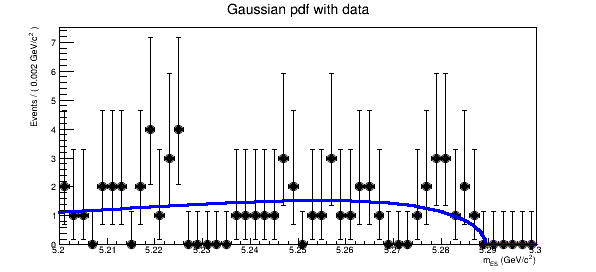

In [218]:
xframe2 = x.frame(ROOT.RooFit.Title("Gaussian pdf with data"),   ROOT.RooFit.Bins(50))  # RooPlot
#xframe2 = x.frame(ROOT.RooFit.Title("extended ML fit example"), ROOT.RooFit.Bins(25))

#del c2
c2 = ROOT.TCanvas("testingfits", "testingfits", 600, 300)#"fit", "fit", 600, 600)

ds_x.plotOn(xframe2)

total.plotOn(xframe2, ROOT.RooFit.Normalization(1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_bkg = ROOT.RooArgSet(sub_funcs['bkg_pdf'])
total.plotOn(
    xframe2, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

## Overlay the background component of model with a dashed line
#ras_sig = ROOT.RooArgSet(sig_pdf)
#total.plotOn(
#    xframe2, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(
#        ROOT.kDotted), ROOT.RooFit.Normalization(
#            1.0, ROOT.RooAbsReal.RelativeExpected))

xframe2.Draw()
c2.Draw()

# Signal

In [219]:
# Bkg only
total = ROOT.RooExtendPdf("fit_func", "Extended function for signal", sub_funcs["sig_pdf"], pars_d["nsig"])

total.Print("v")

--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes: 
  Address: 0x561e06cc5c10
  Clients: 
  Servers: 
    (0x561e06cf26c0,V-) RooCBShape::sig_pdf "Crystal Barrel Shape PDF"
    (0x561e06cf6c20,V-) RooFormulaVar::nsig "conv_factor_fit*branching_fraction"
  Proxies: 
    pdf -> sig_pdf
    n -> nsig
--- RooAbsReal ---

  Plot label is "sig_pdf"
--- RooAbsPdf ---
Cached value = 0


In [220]:
# BNC
#'''
mask = (df_sp['used_in_bkg_train'] == False)
mask &= mask & (df_sp['used_in_sig_train'] == False)
mask &= mask & (df_sp['cut_2']==True) & (df_sp['cut_3']==True) & (df_sp['cut_4']==True)
mask &= mask & (df_sp['BpostFitDeltaE']<0.05) & (df_sp['BpostFitDeltaE']>-0.05)
mask &= mask & (df_sp['proba']>proba_cut)

mask_sp = (df_sp['spmode']=='-999')
df_tmp1 = df_sp[mask & mask_sp]
#'''

# BNV
'''
mask = (df_sp['used_in_sig_train'] == False)
mask &= mask & (df_sp['cut_-1']==True)
mask &= mask & (df_sp['BpostFitDeltaE']<0.05) & (df_sp['BpostFitDeltaE']>-0.05)
mask &= mask & (df_sp['proba']>0.10)

mask_sp = (df_sp['spmode']=='-999')
df_tmp1 = df_sp[mask & mask_sp]
'''

#mask_sp = (df_sp['spmode']=='-999')
#df_tmp2 = df_sp[mask & mask_sp].sample(n=4)

#df_tmp = pd.concat([df_tmp1, df_tmp2])
df_tmp = df_tmp1

#ds = read_file_return_dataset(df_sp[mask], x, y, region_definitions=region_definitions)
ds = read_file_return_dataset(df_tmp, x, y, region_definitions=region_definitions)

ds_x = ds.reduce(x)

ds_x.Print("v")

Data ranges...
5.2 5.3
-0.2 0.2
DataStore dataset_0 (dataset_0)
  Contains 16458 entries
  Observables: 
    1)  x = 5.28  L(5.2 - 5.3) // [GeV/c^{2}] "m_{ES}"


In [221]:
pars_d.keys()

dict_keys(['nbkg', 'nsig', 'log_gc', 'conv_factor_calc', 'conv_factor_fit', 'conv_factor_err', 'branching_fraction', 'meanCB', 'sigmaCB', 'alphaCB', 'nCB', 'argpar', 'cutoff'])

In [222]:
'''
pars_d["nbkg"].setVal(ds_x.sumEntries())
pars_d["nbkg"].setConstant(False)

pars_d["argpar"].setVal(-23.5)
pars_d["argpar"].setConstant(False)

pars_d["cutoff"].setVal(5.29)
pars_d["cutoff"].setConstant(False)


# Bkg only
total = ROOT.RooExtendPdf("fit_func", "Extended function for background", sub_funcs["bkg_pdf"], pars_d["nbkg"])

total.Print("v")

# Create the NLL for the fit
nll = ROOT.RooNLLVar("nll","nll",total, ds_x, ROOT.RooFit.Extended(ROOT.kTRUE))
fit_func = ROOT.RooFormulaVar("fit_func","nll + log_gc", ROOT.RooArgList(nll,pars_d["log_gc"]))

m = ROOT.RooMinimizer(fit_func)

m.setVerbose(ROOT.kFALSE)


m.migrad()
m.hesse()
fit_results = m.save()


fit_results.Print("v")
'''

'\npars_d["nbkg"].setVal(ds_x.sumEntries())\npars_d["nbkg"].setConstant(False)\n\npars_d["argpar"].setVal(-23.5)\npars_d["argpar"].setConstant(False)\n\npars_d["cutoff"].setVal(5.29)\npars_d["cutoff"].setConstant(False)\n\n\n# Bkg only\ntotal = ROOT.RooExtendPdf("fit_func", "Extended function for background", sub_funcs["bkg_pdf"], pars_d["nbkg"])\n\ntotal.Print("v")\n\n# Create the NLL for the fit\nnll = ROOT.RooNLLVar("nll","nll",total, ds_x, ROOT.RooFit.Extended(ROOT.kTRUE))\nfit_func = ROOT.RooFormulaVar("fit_func","nll + log_gc", ROOT.RooArgList(nll,pars_d["log_gc"]))\n\nm = ROOT.RooMinimizer(fit_func)\n\nm.setVerbose(ROOT.kFALSE)\n\n\nm.migrad()\nm.hesse()\nfit_results = m.save()\n\n\nfit_results.Print("v")\n'

In [223]:
# Create the NLL for the fit

print(f"nevents: {ds_x.sumEntries()}")

pars_d["nCB"].setVal(1.0)
pars_d["nCB"].setConstant(True)

#pars_d["conv_factor_calc"].setVal(43.)
pars_d["conv_factor_calc"].setVal(13.)
pars_d["conv_factor_calc"].setConstant(True)

#pars_d["conv_factor_fit"].setVal(43.)
pars_d["conv_factor_fit"].setVal(13.)
pars_d["conv_factor_fit"].setConstant(False)

pars_d["conv_factor_err"].setVal(500)
pars_d["conv_factor_err"].setConstant(True)

#pars_d["branching_fraction"].setVal(0.58)
pars_d["branching_fraction"].setVal(12.2)
pars_d["branching_fraction"].setConstant(True)

pars_d["meanCB"].setVal(5.279)
pars_d["meanCB"].setConstant(True)

pars_d["sigmaCB"].setVal(0.0028)
pars_d["sigmaCB"].setConstant(False)

pars_d["alphaCB"].setVal(2.000)
pars_d["alphaCB"].setConstant(False)

nll = ROOT.RooNLLVar("nll","nll", total, ds_x, ROOT.RooFit.Extended(ROOT.kTRUE))

fit_func = ROOT.RooFormulaVar("fit_func","nll + log_gc", ROOT.RooArgList(nll,pars_d["log_gc"]))

m = ROOT.RooMinimizer(fit_func)

m.setVerbose(ROOT.kTRUE)
m.setMaxFunctionCalls(1000)
m.setMaxIterations(1000)


m.migrad()

print("After migrad")
fit_results = m.save()
fit_results.Print("v")

m.hesse()
fit_results = m.save()
fit_results.Print("v")

mynsig = pars_d["conv_factor_fit"].getVal() * pars_d["branching_fraction"].getVal()
print(f"mynsig: {mynsig}    nsig: {pars_d['nsig'].getVal()}")


fit_results.Print("v")


nevents: 16458.0
After migrad
mynsig: 21797.983415774328    nsig: 21797.983415774328
[#1] INFO:Minimization -- RooFormulaVar::defaultErrorLevel(fit_func) Formula contains a RooNLLVar, using its error level
[#0] WARNING:Minimization -- RooAbsMinimizerFcn::synchronize: WARNING: no initial error estimate available for alphaCB: using 1
[#0] WARNING:Minimization -- RooAbsMinimizerFcn::synchronize: WARNING: no initial error estimate available for conv_factor_fit: using 1
[#0] WARNING:Minimization -- RooAbsMinimizerFcn::synchronize: WARNING: no initial error estimate available for sigmaCB: using 1
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1

prevFCN = -156272.4224  alphaCB=2.273, 
prevFCN = -156836.5007  alphaCB=1.727, 
prevFCN = -155319.3608  alphaCB=2.027, 
prevFCN = -156344.3283  alphaCB=1.973, 
prevFCN = -156196.6198  alphaCB=2, conv_factor_fit=13.27, 
prevFCN = -156611.1032  conv_factor_fit=12.73, 
prevFCN = -155926.4832  conv_factor_fit=13.03, 
prev

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -156272.4224 Edm =       11430.13342 NCalls =     15
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -156272.4224
  Edm           : 11430.13342
  Internal parameters:	[                2               13           0.0028]	
  Internal gradient  :	[     -2705.506724      -1253.80191     -5380894.349]	
  Internal covariance matrix:
[[  0.00038245465              0              0]
 [              0    0.020537077              0]
 [              0              0  3.6735392e-10]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -156272.4224 Edm =       11430.13342 NCalls =     15
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -180354.5957 Edm =       36.03140064 NCalls =     38
Info in <Minuit2>: VariableMe

In [224]:
pars_d['nsig'].Print("v")

print(pars_d["nsig"].evaluate())



21797.983415774328
--- RooAbsArg ---
  Value State: clean
  Shape State: DIRTY
  Attributes: 
  Address: 0x561e06cf6c20
  Clients: 
    (0x561e06cc5c10,V-) RooExtendPdf::fit_func "Extended function for signal"
  Servers: 
    (0x561e067373b0,V-) RooRealVar::conv_factor_fit "Conversion factor (fit)"
    (0x561e06bff5d0,V-) RooRealVar::branching_fraction "Branching fraction"
  Proxies: 
    actualVars -> 
      1)     conv_factor_fit
      2)  branching_fraction
--- RooAbsReal ---

  Plot label is "nsig"
    --- RooFormula ---
   Formula:        'conv_factor_fit*branching_fraction'
   Interpretation: 'conv_factor_fit*branching_fraction'
    Servers: (conv_factor_fit,branching_fraction)
    In use : (conv_factor_fit,branching_fraction)


[#1] INFO:Plotting -- RooAbsPdf::plotOn(fit_func) directly selected PDF components: (sig_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fit_func) indirectly selected PDF components: ()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: testingfits


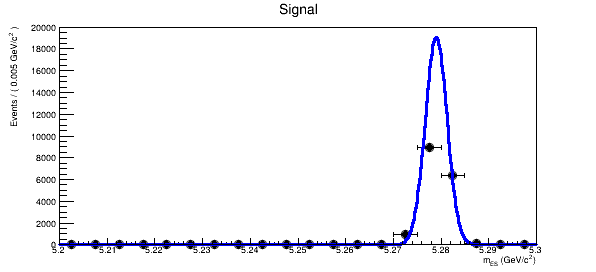

In [225]:
xframe3 = x.frame(ROOT.RooFit.Title("Signal"),   ROOT.RooFit.Bins(20))  # RooPlot

#del c2
c3 = ROOT.TCanvas("testingfits", "testingfits", 600, 300)#"fit", "fit", 600, 600)

ds_x.plotOn(xframe3)

total.plotOn(xframe3, ROOT.RooFit.Normalization(1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
#ras_bkg = ROOT.RooArgSet(bkg_pdf)
#total.plotOn(
#    xframe2, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
#        ROOT.kDashed), ROOT.RooFit.Normalization(
#            1.0, ROOT.RooAbsReal.RelativeExpected))

## Overlay the signal component of model with a dashed line
ras_sig = ROOT.RooArgSet(sub_funcs['sig_pdf'])
total.plotOn(
    xframe3, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(
        ROOT.kDotted), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

xframe3.Draw()
c3.Draw()

# Full fit?

In [226]:
df_sp = pd.read_parquet(infilename_sp)
df_col = pd.read_parquet(infilename_col)

#df_sp = pd.read_parquet("DATAFRAME_SP_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000.pkl")
#df_col = pd.read_parquet("DATAFRAME_COL_MODEL_MLPClassifier_CUTS_1_2_3_nsig_20000_nbkg_20000.pkl")

In [227]:
mes_lo, mes_hi = 5.2,5.3

# Trying this for BNV mode
#mes_lo, mes_hi = 5.21,5.3
#deltae_lo, deltae_hi = -0.07,0.07

# BNC
#deltae_lo, deltae_hi = -0.2,0.2
deltae_lo, deltae_hi = -0.05,0.05

x,y = pdfs.build_xy([[mes_lo, mes_hi], [deltae_lo, deltae_hi]])


x.setRange("FULL",mes_lo,mes_hi)
y.setRange("FULL",deltae_lo, deltae_hi)

x.setRange("SIGNAL",5.25, mes_hi)
y.setRange("SIGNAL",-0.10, 0.1)

# Sideband 1 region
x.setRange("SB1", mes_lo,  mes_hi)
y.setRange("SB1", 0.075, deltae_hi)

# Sideband 2 region
x.setRange("SB2",  mes_lo,  mes_hi)
y.setRange("SB2", deltae_lo, -0.075)

# Sideband 3 region
x.setRange("SB3",  mes_lo,  5.27)
#y.setRange("SB3", -0.075, 0.075)
y.setRange("SB3", -0.05, 0.05)



[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'FULL' created with bounds [5.2,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'FULL' created with bounds [-0.05,0.05]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SIGNAL' created with bounds [5.25,5.3]
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SIGNAL' created with bounds [-0.1,0.1]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SB1' created with bounds [5.2,5.3]
[#0] WARNING:InputArguments -- RooRealVar::setRange(y): Proposed new fit max. smaller than min., setting max. to min.
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SB1' created with bounds [0.075,0.05]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'SB2' created with bounds [5.2,5.3]
[#0] WARNING:InputArguments -- RooRealVar::setRange(y): Proposed new fit max. smaller than min., setting max. to min.
[#1] INFO:Eval -- RooRealVar::setRange(y) new range named 'SB2' created with bounds [-0.05

In [228]:
ds_x = ds.reduce(x)

In [229]:
mypars = []

dum_pars, sub_funcs_list, total = pdfs.tot_PDF(x, ds_x)#, use_double_cb, workspace)

mypars += dum_pars


total.Print("v")

[#1] INFO:InputArguments -- The formula log_gc claims to use the variables (conv_factor_calc,conv_factor_fit,conv_factor_calc,conv_factor_fit,conv_factor_err,conv_factor_err) but only (conv_factor_calc,conv_factor_fit,conv_factor_err) seem to be in use.
  inputs:         (conv_factor_calc-conv_factor_fit)*(conv_factor_calc-conv_factor_fit)/(2.0*conv_factor_err*conv_factor_err)
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes: 
  Address: 0x561e05f07220
  Clients: 
  Servers: 
    (0x561e07220850,V-) RooCBShape::sig_pdf "Crystal Barrel Shape PDF"
    (0x561e06c77f50,V-) RooFormulaVar::nsig "conv_factor_fit*branching_fraction"
    (0x561e07215b40,V-) RooArgusBG::bkg_pdf "Argus PDF"
    (0x561e0720aa20,V-) RooRealVar::nbkg "# bkg events,"
  Proxies: 
    !refCoefNorm -> 
    !pdfs -> 
      1)  sig_pdf
      2)  bkg_pdf
    !coefficients -> 
      1)  nsig
      2)  nbkg
--- RooAbsReal ---

  Plot label is "total"
--- RooAbsPdf ---
Cached value = 0


In [230]:
# Create a dictionary of the pars
# We'll use this later if we need to print stuff out.
#print mypars
pars_d = {}
for p in mypars:
    pars_d[p.GetName()] = p

# Create a dictionary of extra functions
# We'll use this later if we need to print stuff out.
#print sub_funcs_list
sub_funcs = {}
for f in sub_funcs_list:
    sub_funcs[f.GetName()] = f


In [231]:
for p in pars_d.keys():
    print(f"{p} ---------------------")
    #pars_d[p].Print("v")

nbkg ---------------------
nsig ---------------------
log_gc ---------------------
conv_factor_calc ---------------------
conv_factor_fit ---------------------
conv_factor_err ---------------------
branching_fraction ---------------------
meanCB ---------------------
sigmaCB ---------------------
alphaCB ---------------------
nCB ---------------------
argpar ---------------------
cutoff ---------------------


In [232]:
#df_sp = pd.read_parquet("DATAFRAME_SP_BNC_ALL.parquet")
#df_col = pd.read_parquet("DATAFRAME_COL_BNC_ALL.parquet")

In [233]:
#############################################################
# SP
#############################################################
#'''
# BNC
'''
df_for_fit = df_sp

#mask = (df_sp['spmode']=='998')
mask = (df_for_fit['used_in_bkg_train'] == False)
mask &= mask & (df_for_fit['used_in_sig_train'] == False)
mask &= mask & (df_for_fit['cut_2']==True) & (df_for_fit['cut_3']==True) & (df_for_fit['cut_4']==True)
mask &= mask & (df_for_fit['BpostFitDeltaE']<0.05) & (df_for_fit['BpostFitDeltaE']>-0.05)
mask &= mask & (df_for_fit['proba']>0.97)

mask_sp = (df_for_fit['spmode']=='998')
df_tmp1 = df_for_fit[mask & mask_sp]

mask_sp = (df_for_fit['spmode']=='-999')
df_tmp2 = df_for_fit[mask & mask_sp].sample(n=8)

df_tmp = pd.concat([df_tmp1, df_tmp2])
#df_tmp = df_tmp1
'''
# BNV
'''
df_for_fit = df_sp

#mask = (df_sp['spmode']=='998')
mask = (df_for_fit['used_in_bkg_train'] == False)
mask &= mask & (df_for_fit['used_in_sig_train'] == False)
mask &= mask & (df_for_fit['cut_-1']==True)
mask &= mask & (df_for_fit['BpostFitDeltaE']<0.07) & (df_for_fit['BpostFitDeltaE']>-0.07)
mask &= mask & (df_for_fit['proba']>0.84)

mask_sp = (df_for_fit['spmode']=='998')
df_tmp1 = df_for_fit[mask & mask_sp].sample(6)

mask_sp = (df_for_fit['spmode']=='-999')
df_tmp2 = df_for_fit[mask & mask_sp].sample(n=4)

df_tmp = pd.concat([df_tmp1, df_tmp2])
'''


#'''
#############################################################
# Collision
#############################################################

#'''
df_for_fit = df_col

# BNC
#proba_cut = 0.80
mask = (df_for_fit['cut_2']==True) & (df_for_fit['cut_3']==True) & (df_for_fit['cut_4']==True)
mask &= mask & (df_for_fit['BpostFitDeltaE']<0.07) & (df_for_fit['BpostFitDeltaE']>-0.07)
mask &= mask & (df_for_fit['proba']>proba_cut)

# BNV
#mask = (df_for_fit['cut_-1']==True)
#mask &= mask & (df_for_fit['BpostFitDeltaE']<0.07) & (df_for_fit['BpostFitDeltaE']>-0.07)
#mask &= mask & (df_for_fit['proba']>0.87)

df_tmp = df_for_fit[mask]
#df_tmp = df_tmp1
#'''


#ds = read_file_return_dataset(df_sp[mask], x, y, region_definitions=region_definitions)
ds = read_file_return_dataset(df_tmp, x, y, region_definitions=region_definitions)

ds_x = ds.reduce(x)

ds_x.Print("v")

Data ranges...
5.2 5.3
-0.2 0.2
DataStore dataset_0 (dataset_0)
  Contains 185 entries
  Observables: 
    1)  x = 5.21  L(5.2 - 5.3) // [GeV/c^{2}] "m_{ES}"


In [234]:
#auto mu = (RooRealVar*)params.find("mu");
#mu->setValueDirty();

# Do I need to do this? 
# https://github.com/root-project/root/issues/7659

pars_d['conv_factor_fit'].setValueDirty()

In [235]:

# Can we reduce the data for just sidebands?
#reduced_data = ds.reduce(ROOT.RooFit.CutRange("SB1"))
#reduced_data.append(ds.reduce(ROOT.RooFit.CutRange("SB2")))
#reduced_data.append(ds.reduce(ROOT.RooFit.CutRange("SB3")))
reduced_data = ds.reduce(ROOT.RooFit.CutRange("SB3"))

reduced_data_x = reduced_data.reduce(x)


# Background
pars_d["nbkg"].setVal(reduced_data_x.sumEntries())
pars_d["argpar"].setVal(-23.5)
pars_d["cutoff"].setVal(5.29)

pars_d["nbkg"].setConstant(False)
pars_d["argpar"].setConstant(False)
pars_d["cutoff"].setConstant(True)

## Signal

# BNC
pars_d["conv_factor_calc"].setVal(2.333e7)
pars_d["conv_factor_fit"].setVal(2.333e7)
pars_d["conv_factor_err"].setVal(7.551e5)
pars_d["branching_fraction"].setVal(0)

pars_d["nCB"].setVal(1.0)
pars_d["meanCB"].setVal(5.279)
pars_d["sigmaCB"].setVal(2.7035e-03)
pars_d["alphaCB"].setVal(16.27)

pars_d["nCB"].setConstant(True)
pars_d["conv_factor_calc"].setConstant(True)
pars_d["conv_factor_fit"].setConstant(True)
pars_d["conv_factor_err"].setConstant(True)
pars_d["branching_fraction"].setConstant(True)
pars_d["meanCB"].setConstant(True)
pars_d["sigmaCB"].setConstant(True)
pars_d["alphaCB"].setConstant(True)



# Create the NLL for the fit
nll = ROOT.RooNLLVar("nll","nll", total, reduced_data_x, ROOT.RooFit.Extended(ROOT.kTRUE))
#fit_func = ROOT.RooFormulaVar("fit_func","nll + log_gc",ROOT.RooArgList(nll,pars_d["log_gc"]))

# Should I use RooAddition as mentioned here
# https://root.cern/doc/v612/classRooMinimizer.html
fit_func = ROOT.RooAddition("fit_func","sum of nll and log_gc",ROOT.RooArgList(nll,pars_d["log_gc"]))
# No gives same result with no asymmetric uncertainties

nll.setValueDirty()
fit_func.setValueDirty()

print("Setting up the minimizer..................................")
m = ROOT.RooMinimizer(fit_func)
#m = ROOT.RooMinimizer(nll)

# For NLL?
m.setErrorLevel(0.5)
m.setVerbose(ROOT.kTRUE)
m.setStrategy(2)

print("Helping get the initial step size.........................")
m.hesse()

print("Performing the minimizations..............................")
m.migrad()

print("Calculating the uncertainties..............................")
m.hesse()

fit_results = m.save()


fit_results.Print("v")


Setting up the minimizer..................................
Helping get the initial step size.........................
Performing the minimizations..............................
Calculating the uncertainties..............................
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(fit_func) Summation contains a RooNLLVar, using its error level
[#0] WARNING:Minimization -- RooMinimizer::hesse: Error, run Migrad before Hesse!
[#0] WARNING:Minimization -- RooAbsMinimizerFcn::synchronize: WARNING: no initial error estimate available for argpar: using 1
[#0] WARNING:Minimization -- RooAbsMinimizerFcn::synchronize: WARNING: no initial error estimate available for nbkg: using 1
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 2

prevFCN = -984.1668948  argpar=-23.48, 
prevFCN = -984.1755831  argpar=-23.52, 
prevFCN = -984.1582007  argpar=-23.31, 
prevFCN = -984.244871  argpar=-23.69, 
prevFCN = -984.0884491  argpar=-23.5, nbkg=151, 
prevFCN = -984.1668933

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -984.1668948 Edm =       6.514031802 NCalls =      9
Info in <Minuit2>: MnSeedGenerator run Hesse - Initial seeding state: 
  Minimum value : -984.1668948
  Edm           : 6.514029486
  Internal parameters:	[            -23.5              151]	
  Internal gradient  :	[     -0.401097623 -6.558288408e-11]	
  Internal covariance matrix:
[[      161.96066              0]
 [              0      301.99969]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -984.1668948 Edm =       6.514029486 NCalls =     25
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -990.7967812 Edm =    0.005947504057 NCalls =     30
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =      -990.8031983 Edm =   1.355652162e-05 NCalls =     35
Info in <M

[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) directly selected PDF components: (bkg_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) directly selected PDF components: (sig_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) indirectly selected PDF components: ()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: testingfits4
Info in <TCanvas::Print>: png file testfit_BNC.png has been created


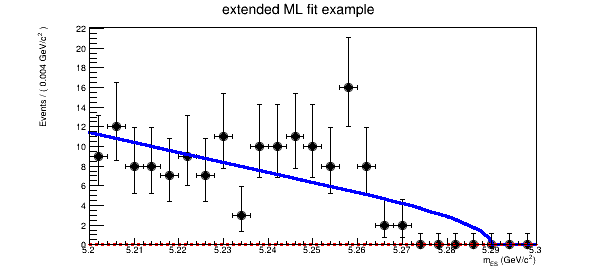

In [236]:
#################################
# Reduced
########################################

#del c
c4 = ROOT.TCanvas("testingfits4", "testingfits4", 600, 300)#"fit", "fit", 600, 600)
# Plot data and PDF overlaid, expected number of events for p.d.f projection normalization
# rather than observed number of events (==data.numEntries())
xframe4 = x.frame(ROOT.RooFit.Title("extended ML fit example"), ROOT.RooFit.Bins(25))
reduced_data_x.plotOn(xframe4)
total.plotOn(xframe4, ROOT.RooFit.Normalization(
    1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_bkg = ROOT.RooArgSet(sub_funcs['bkg_pdf'])
total.plotOn(
    xframe4, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_sig = ROOT.RooArgSet(sub_funcs['sig_pdf'])
total.plotOn(
    xframe4, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.LineColor("r") , ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Draw the frame on the canvas

ROOT.gPad.SetLeftMargin(0.15)
xframe4.GetYaxis().SetTitleOffset(1.4)
xframe4.Draw()



#c.Update()
#ROOT.gPad
c4.Draw()
#ROOT.gPad.Draw()
#ROOT.gPad.Update()
#c.Draw()

c4.SaveAs("testfit_BNC.png")



In [237]:
mypars = []
dum_pars, sub_funcs_list, total = pdfs.tot_PDF(x, ds_x)#, use_double_cb, workspace)
mypars += dum_pars
total.Print("v")

# Create a dictionary of the pars
# We'll use this later if we need to print stuff out.
#print mypars
pars_d = {}
for p in mypars:
    pars_d[p.GetName()] = p

# Create a dictionary of extra functions
# We'll use this later if we need to print stuff out.
#print sub_funcs_list
sub_funcs = {}
for f in sub_funcs_list:
    sub_funcs[f.GetName()] = f






# Background
pars_d["nbkg"].setVal(ds_x.sumEntries())
#pars_d["argpar"].setVal(-23.5)
#pars_d["cutoff"].setVal(5.29)

pars_d["nbkg"].setConstant(False)
pars_d["argpar"].setConstant(False)
pars_d["cutoff"].setConstant(True)

## Signal

# BNC
pars_d["conv_factor_calc"].setVal(2.333e7)
pars_d["conv_factor_fit"].setVal(2.333e7)
pars_d["conv_factor_err"].setVal(7.551e5)
pars_d["branching_fraction"].setVal(2.0e-7)

pars_d["nCB"].setVal(1.0)
pars_d["meanCB"].setVal(5.279)
pars_d["sigmaCB"].setVal(2.7035e-03)
pars_d["alphaCB"].setVal(16.27)

pars_d["nCB"].setConstant(True)
pars_d["conv_factor_calc"].setConstant(True)
pars_d["conv_factor_fit"].setConstant(False)
pars_d["conv_factor_err"].setConstant(True)
pars_d["branching_fraction"].setConstant(False)
pars_d["meanCB"].setConstant(True)
pars_d["sigmaCB"].setConstant(True)
pars_d["alphaCB"].setConstant(True)

# Bkg only

total.Print("v")

# Create the NLL for the fit
nll = ROOT.RooNLLVar("nll","nll", total, ds_x, ROOT.RooFit.Extended(ROOT.kTRUE))
#fit_func = ROOT.RooFormulaVar("fit_func","nll + log_gc",ROOT.RooArgList(nll,pars_d["log_gc"]))

# Should I use RooAddition as mentioned here
# https://root.cern/doc/v612/classRooMinimizer.html
fit_func = ROOT.RooAddition("fit_func","sum of nll and log_gc",ROOT.RooArgList(nll,pars_d["log_gc"]))
# No gives same result with no asymmetric uncertainties

nll.setValueDirty()
fit_func.setValueDirty()

print("Setting up the minimizer..................................")
m = ROOT.RooMinimizer(fit_func)
#m = ROOT.RooMinimizer(nll)

# For NLL?
m.setErrorLevel(0.5)


m.setVerbose(ROOT.kTRUE)
m.setStrategy(2)

print("Helping get the initial step size.........................")
m.hesse()

print("Performing the minimizations..............................")
m.migrad()

print("Calculating the uncertainties..............................")
m.hesse()

# Does this matter?
#m.migrad()
#m.hesse()

fit_results = m.save()


fit_results.Print("v")





Setting up the minimizer..................................
Helping get the initial step size.........................
Performing the minimizations..............................
Calculating the uncertainties..............................
[#1] INFO:InputArguments -- The formula log_gc claims to use the variables (conv_factor_calc,conv_factor_fit,conv_factor_calc,conv_factor_fit,conv_factor_err,conv_factor_err) but only (conv_factor_calc,conv_factor_fit,conv_factor_err) seem to be in use.
  inputs:         (conv_factor_calc-conv_factor_fit)*(conv_factor_calc-conv_factor_fit)/(2.0*conv_factor_err*conv_factor_err)
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes: 
  Address: 0x561e07608440
  Clients: 
  Servers: 
    (0x561e076053a0,V-) RooCBShape::sig_pdf "Crystal Barrel Shape PDF"
    (0x561e07609ba0,V-) RooFormulaVar::nsig "conv_factor_fit*branching_fraction"
    (0x561e06c7a560,V-) RooArgusBG::bkg_pdf "Argus PDF"
    (0x561e07606df0,V-) RooRealVar::nbkg "# bkg ev

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       -1230.58963 Edm =       71376.91539 NCalls =     23
Info in <Minuit2>: MnSeedGenerator run Hesse - Initial seeding state: 
  Minimum value : -1230.58963
  Edm           : 0.1692345811
  Internal parameters:	[              -20            2e-07         23330000              185]	
  Internal gradient  :	[    0.04954455657     -4138631.175 -3.547905948e-08    0.02969579619]	
  Internal covariance matrix:
[[      146.01399  1.3014401e-10       221808.2      -9.401476]
 [  1.3014401e-10  2.0557594e-17 -8.5229648e-06 -1.3272521e-10]
 [       221808.2 -8.5229648e-06  1.1391818e+12     -225979.14]
 [      -9.401476 -1.3272521e-10     -225979.14      390.91894]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 2000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =       -1230.58963 Edm =      0.16923

[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) directly selected PDF components: (bkg_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) directly selected PDF components: (sig_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(total) indirectly selected PDF components: ()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: testingfits4
Info in <TCanvas::Print>: png file testfit_BNC.png has been created


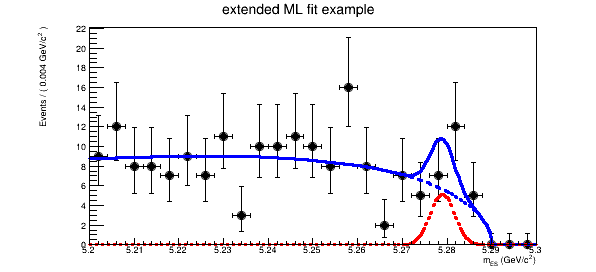

In [238]:
#del c
c4 = ROOT.TCanvas("testingfits4", "testingfits4", 600, 300)#"fit", "fit", 600, 600)
# Plot data and PDF overlaid, expected number of events for p.d.f projection normalization
# rather than observed number of events (==data.numEntries())
xframe4 = x.frame(ROOT.RooFit.Title("extended ML fit example"), ROOT.RooFit.Bins(25))
ds_x.plotOn(xframe4)
total.plotOn(xframe4, ROOT.RooFit.Normalization(
    1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_bkg = ROOT.RooArgSet(sub_funcs['bkg_pdf'])
total.plotOn(
    xframe4, ROOT.RooFit.Components(ras_bkg), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Overlay the background component of model with a dashed line
ras_sig = ROOT.RooArgSet(sub_funcs['sig_pdf'])
total.plotOn(
    xframe4, ROOT.RooFit.Components(ras_sig), ROOT.RooFit.LineStyle(
        ROOT.kDashed), ROOT.RooFit.LineColor("r") , ROOT.RooFit.Normalization(
            1.0, ROOT.RooAbsReal.RelativeExpected))

# Draw the frame on the canvas

ROOT.gPad.SetLeftMargin(0.15)
xframe4.GetYaxis().SetTitleOffset(1.4)
xframe4.Draw()



#c.Update()
#ROOT.gPad
c4.Draw()
#ROOT.gPad.Draw()
#ROOT.gPad.Update()
#c.Draw()

c4.SaveAs("testfit_BNC.png")



[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_Profile[branching_fraction]) Creating instance of MINUIT
[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_Profile[branching_fraction]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_Profile[branching_fraction]) minimum found at (branching_fraction=3.708e-07)
..................................

Warning in <TCanvas::Constructor>: Deleting canvas with same name: testingfits5


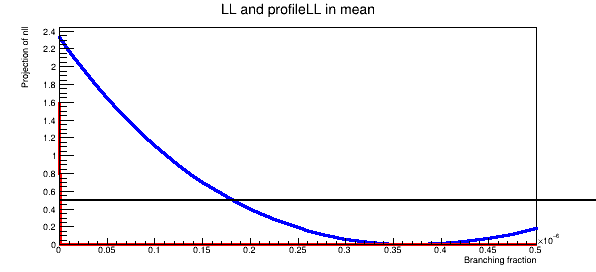

In [239]:
c5 = ROOT.TCanvas("testingfits5", "testingfits5", 600, 300)#"fit", "fit", 600, 600)
#frame1 = mean.frame(Bins=10, Range=(-0.5, 0.5), Title="LL and profileLL in mean")

#frame1 = pars_d['branching_fraction'].frame(Bins=10, Range=(0.0, 1.5), Title="LL and profileLL in mean")
frame1 = pars_d['branching_fraction'].frame(Bins=10, Range=(0.0, 5e-7), Title="LL and profileLL in mean")
nll.plotOn(frame1, ShiftToZero=True)

pll_conv = nll.createProfile({pars_d['branching_fraction']})
pll_conv.plotOn(frame1, LineColor="r")

# Adjust frame maximum for visual clarity
frame1.SetMinimum(0)
#frame1.SetMaximum(0.1)

c5.cd()

line = ROOT.TLine(0, 0.5, 1.5, 0.5)
line.SetLineColor(ROOT.kBlack)
line.SetLineWidth(2)

frame1.Draw()
c5.Draw()
line.Draw()

In [240]:
dx = 1e-7

vals = []

for r in np.arange(0.0, 5e-7, 1e-8):

    pars_d['branching_fraction'].setVal(r)
    v = pll_conv.getVal()
    #print(f'{r:.2f}    {v:.4f}')
    if np.abs(v - 0.5) < dx:
        vals.append(r)

vals = np.array(vals)

print(vals)

central_val = 0.31497

print(vals - central_val)

# 0.16 3.15 0.525

[]
[]

[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_Profile[branching_fraction]) Creating instance of MINUIT
[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_Profile[branching_fraction]) determining minimum likelihood for current configurations w.r.t all observable
[#0] ERROR:InputArguments -- total: calculated negative expected events: -5.646e+05
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (563258) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	argpar=-20.2187	branching_fraction=-0.0242104	conv_factor_fit=2.33295e+07	nbkg=176.387
RooAddPdf::total[ nsig * sig_pdf + nbkg * bkg_pdf ]
     getLogVal() top-level p.d.f evaluates to a negative number @ !refCoefNorm=(), !pdfs=(sig_pdf = 1.77348e-60/0.00677667,bkg_pdf = 0.487136/0.0390172), !coefficients=(nsig = -564817,nbkg = 176.387 +/- 14.0117)
     getLogVal() top-level p.d.f evaluates to a negative number @ !refCoefNorm=(), !pdfs=(sig_pdf = 2.28354e-6

Warning in <TCanvas::Constructor>: Deleting canvas with same name: testingfits6


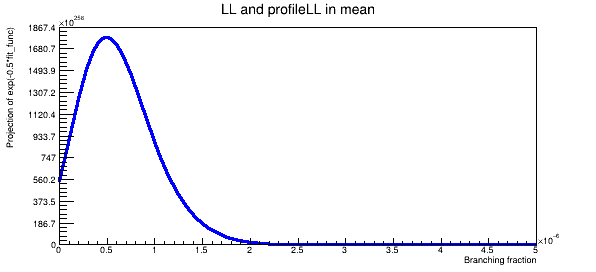

In [241]:
llhood = ROOT.RooFormulaVar("llhood","exp(-0.5*fit_func)", ROOT.RooArgList(fit_func));

#pll_conv = nll.createProfile({pars_d['conv_factor_fit']})

#llhoodP = ROOT.RooFormulaVar("llhoodP","exp(-0.5*pll_conv)", ROOT.RooArgList(pll_conv));

llhoodN = ROOT.RooFormulaVar("llhoodN","exp(-0.5*fit_func)",ROOT.RooArgList(fit_func));

c6 = ROOT.TCanvas("testingfits6", "testingfits6", 600, 300)#"fit", "fit", 600, 600)

frame3 = pars_d['branching_fraction'].frame(Bins=10, Range=(0.0, 5e-6), Title="LL and profileLL in mean")

llhoodN.plotOn(frame3)

frame3.Draw()
c6.Draw()

In [242]:
pars_d['branching_fraction'].setVal(1.38e-7)
nll_min = nll.getVal()

pars_d['branching_fraction'].setVal(0)
nll_0 = nll.getVal()

print(f'nll_min: {nll_min}')
print(f'nll_0: {nll_0}')

sigma = np.sqrt(2*(nll_0-nll_min))
print(f"sigma: {sigma}")

nll_min: -1229.9885498053322
nll_0: -1228.7275797927732
sigma: 1.5880617195556526


1.2006142026395973e+276
501
[4.9100000000000004e-06, 4.92e-06, 4.93e-06, 4.94e-06, 4.95e-06, 4.96e-06, 4.97e-06, 4.98e-06, 4.9900000000000005e-06, 5e-06]

[#1] INFO:Eval -- RooRealVar::setRange(branching_fraction) new range named 'IntRange1' created with bounds [0,5e-06]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(llhoodN_Int[branching_fraction|IntRange1]) using numeric integrator RooRombergIntegrator to calculate Int(branching_fraction)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(llhoodN_Int[branching_fraction|IntRange1]) using numeric integrator RooRombergIntegrator to calculate Int(branching_fraction)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(llhoodN_Int[branching_fraction|IntRange1]) using numeric integrator RooRombergIntegrator to calculate Int(branching_fraction)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(llhoodN_Int[branching_fraction|IntRange1]) using numeric integrator RooRombergIntegrator to calculate Int(branching_fraction)
[#1] INF

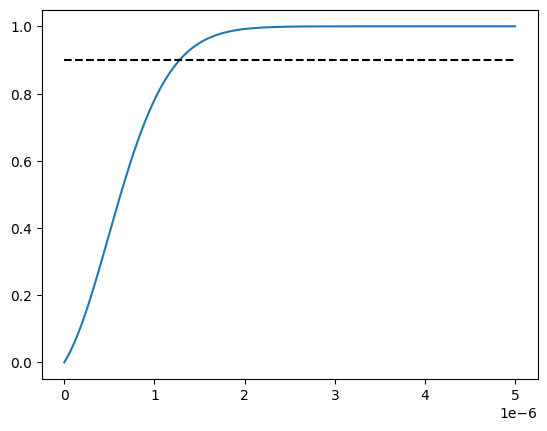

In [137]:
pars_d['branching_fraction'].setRange("IntRange1",0,5e-6)

total_int_val = llhoodN.createIntegral(ROOT.RooArgSet(pars_d['branching_fraction']),ROOT.RooFit.Range('IntRange1'))

print(total_int_val.getVal())

total_int_val = total_int_val.getVal()

xpts = []
ypts = []

for r in np.arange(0.0, 5e-6, 1e-8):
    
    pars_d['branching_fraction'].setRange("IntRange1",0,r)
    
    int_val = llhoodN.createIntegral(ROOT.RooArgSet(pars_d['branching_fraction']),ROOT.RooFit.Range('IntRange1'))
    
    #print(f"{r:.2e}  {int_val.getVal() / total_int_val:.4f}")
    xpts.append(r)
    ypts.append(int_val.getVal() / total_int_val)
;

plt.plot(xpts,ypts)
plt.plot([0,5e-6],[0.90, 0.90],'k--')
print(len(xpts))
print(xpts[-10:])

In [138]:
#pll_conv.getAnalyticalIntegral()

In [139]:
#pll_mean.Print('v')

In [140]:
fit_func.defaultErrorLevel()

0.5

[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(fit_func) Summation contains a RooNLLVar, using its error level


In [141]:
pars_d['log_gc'].getVal()

55.00815095306751

In [142]:
fit_results.Print("v")


  RooFitResult: minimized FCN value: -1354, estimated distance to minimum: 1.378e-07
                covariance matrix quality: Full, accurate covariance matrix
                Status : MIGRAD=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
               alphaCB    1.6270e+01
      conv_factor_calc    2.3330e+07
       conv_factor_err    7.5510e+05
                cutoff    5.2900e+00
                meanCB    5.2790e+00
                   nCB    1.0000e+00
               sigmaCB    2.7035e-03

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                argpar   -2.0000e+01   -2.4491e+01 +/-  9.07e+00  <none>
    branching_fraction    2.0000e-07    3.2270e-07 +/-  2.39e-07  <none>
       conv_factor_fit    2.3330e+07    2.3330e+07 +/-  7.55e+05  <none>
                  nbkg    2.0100e+02    1.9347e+02 +/-  1.47e+01  <none>



In [143]:
fit_results.Print("v")
print()
mynsig = pars_d["conv_factor_fit"].getVal() * pars_d["branching_fraction"].getVal()
print(f"mynsig: {mynsig}    nsig: {pars_d['nsig'].getVal()}")




mynsig: 0.0    nsig: 0.0

  RooFitResult: minimized FCN value: -1354, estimated distance to minimum: 1.378e-07
                covariance matrix quality: Full, accurate covariance matrix
                Status : MIGRAD=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
               alphaCB    1.6270e+01
      conv_factor_calc    2.3330e+07
       conv_factor_err    7.5510e+05
                cutoff    5.2900e+00
                meanCB    5.2790e+00
                   nCB    1.0000e+00
               sigmaCB    2.7035e-03

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                argpar   -2.0000e+01   -2.4491e+01 +/-  9.07e+00  <none>
    branching_fraction    2.0000e-07    3.2270e-07 +/-  2.39e-07  <none>
       conv_factor_fit    2.3330e+07    2.3330e+07 +/-  7.55e+05  <none>
                  nbkg    2.0100e+02    1.9347e+02 +/-  1.47e+01 

In [144]:
fit_results.Print('v')


  RooFitResult: minimized FCN value: -1354, estimated distance to minimum: 1.378e-07
                covariance matrix quality: Full, accurate covariance matrix
                Status : MIGRAD=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
               alphaCB    1.6270e+01
      conv_factor_calc    2.3330e+07
       conv_factor_err    7.5510e+05
                cutoff    5.2900e+00
                meanCB    5.2790e+00
                   nCB    1.0000e+00
               sigmaCB    2.7035e-03

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                argpar   -2.0000e+01   -2.4491e+01 +/-  9.07e+00  <none>
    branching_fraction    2.0000e-07    3.2270e-07 +/-  2.39e-07  <none>
       conv_factor_fit    2.3330e+07    2.3330e+07 +/-  7.55e+05  <none>
                  nbkg    2.0100e+02    1.9347e+02 +/-  1.47e+01  <none>



In [145]:
p = pars_d['conv_factor_fit']

print(p.getErrorLo(), p.getErrorHi())

-10557413.339645848 10557413.339645848


In [146]:
ROOT.TRolke

<class cppyy.gbl.TRolke at 0x561e064acc80>

In [147]:
mc = fit_func
data = ds_x

#pl = ROOT.RooStats.ProfileLikelihoodCalculator(data, mc)


In [92]:
#teststat = ROOT.RooStats.SimpleLikelihoodRatioTestStat(sb_model.GetPdf(), b_model.GetPdf())
teststat = ROOT.RooStats.SimpleLikelihoodRatioTestStat(total, sub_funcs['bkg_pdf'])

#teststat.SetNullParameters(total.GetSnapshot())
#teststat.SetAltParameters(sub_functions['bkg_pdf'].GetSnapshot())

#hc2 = ROOT.RooStats.HybridCalculator(ds_x, sub_funcs['bkg_pdf'], total)





# RooMinimizer example with Hesse

In [ ]:
x = ROOT.RooRealVar ("x", "x", -20, 20)
mean = ROOT.RooRealVar ("mean", "mean", 0, -10, 10)
sigma = ROOT.RooRealVar ("sigma", "width", 3, 1, 10)

# Define a Gaussian PDF
gaus = ROOT.RooGaussian("gauss", "gaussian PDF", x, mean, sigma)

# Create a dataset 
data = gaus.generate(x, 1000)

# Create a negative log likelihood function from the PDF
nll = gaus.createNLL(data)

# 2. Create RooMinimizer
m = ROOT.RooMinimizer(nll)

# 3. Set the minimization strategy
m.setStrategy(1)

# 4. Call migrad() to minimize
m.migrad();

# 5. Call hesse() to perform error analysis
m.hesse()

# 6. Print the results
#print(f"Parameter values:")
#mean.Print()
#sigma.Print()
#print()

results = m.save()
print("Results ---------------------------")
results.Print("v")


In [ ]:
# Make canvas and draw ROOT.RooPlots
c = ROOT.TCanvas("rf605_profilell", "rf605_profilell", 800, 400)

c.Divide(2)

# Plot likelihood scan frac
frame1 = mean.frame(Bins=10, Range=(-0.5, 0.5), Title="LL and profileLL in mean")
nll.plotOn(frame1, ShiftToZero=True)
 
# Plot likelihood scan in sigma_g2
frame2 = sigma.frame(Bins=10, Range=(2.8, 3.2), Title="LL and profileLL in sigma_g2")
nll.plotOn(frame2, ShiftToZero=True)

In [ ]:
# The profile likelihood estimator on nll for frac will minimize nll w.r.t
# all floating parameters except frac for each evaluation
 
pll_mean = nll.createProfile({mean})
 
# Plot the profile likelihood in frac
pll_mean.plotOn(frame1, LineColor="r")
 
# Adjust frame maximum for visual clarity
frame1.SetMinimum(0)
frame1.SetMaximum(3)

In [ ]:

 

 
# Adjust frame maximum for visual clarity
frame2.SetMinimum(0)
frame2.SetMaximum(3)
 

c.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
nll.plotOn(frame1, ShiftToZero=True)
# The profile likelihood estimator on nll for sigma_g2 will minimize nll
# w.r.t all floating parameters except sigma_g2 for each evaluation
pll_sigma = nll.createProfile({sigma})
frame1.GetYaxis().SetTitleOffset(1.4)
frame1.Draw()

c.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
nll.plotOn(frame2, ShiftToZero=True)
# Plot the profile likelihood in sigma_g2
pll_sigma.plotOn(frame2, LineColor="r")

frame2.GetYaxis().SetTitleOffset(1.4)
frame2.Draw()

c.Draw()

In [ ]:
ROOT.__version__